### Pembuatan Model Seluruh Pelabuhan

-

-

In [1]:
# define path
path = "dat_filtered/"

# import library data processing
import pandas as pd
import numpy as np

# import library for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# import self module
from prepare_load import *

# import ML library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

# pycaret regression
#from pycaret.regression import *
from pycaret.classification import *

In [2]:
# load kapal dataset
import xlrd
xlsx = xlrd.open_workbook(path+"dataframe_pivot_pelabuhan_v2.xlsx", on_demand=True)
sheet_names = xlsx.sheet_names()
print(sheet_names)
sheet_names.remove("All")

['All', 'KELAPA_HARAPAN', 'LANCANG', 'MARINA', 'ANGKE', 'PARI', 'PRAMUKA_PANGGANG', 'SABIRA', 'TIDUNG_PAYUNG', 'UNTUNG_JAWA']


In [3]:
# dictionary of kapa dataframe per pelabuhan
df_kapal = {item:pd.read_excel(path+"dataframe_pivot_pelabuhan_v2.xlsx", 
                               sheet_name=item) for item in sheet_names}

# dataframe of new case COVID-19 and Google Mobility
case_mobi_custom = pd.read_excel(path+"New_case_mobility_customDate.xlsx")

# check Shape
print("KELAPA_HARAPAN: ", df_kapal["KELAPA_HARAPAN"].shape)
print("Mobility and New Case custom: ", case_mobi_custom.shape)

KELAPA_HARAPAN:  (578, 14)
Mobility and New Case custom:  (578, 6)


In [4]:
def mobilityTRansform(list_a):
    list_out = []
    for item in list_a:
        if item>=0:
            list_out.append(1)
        elif item<0:
            list_out.append(0)
    return list_out

def labelTransform(list_a):
    import statistics
    before_pandemi = list_a[0:427]
    med_ = statistics.median(before_pandemi)
    list_label = [1 if item >= med_ else 0 for item in list_a]
    return list_label

In [6]:
# concat dataframe
df_cont = pd.DataFrame({})

for item in sheet_names:
    df_procc = df_kapal[item]
    df_procc = df_procc.rename(columns={"Level Pembatasan Darurat": "Level_Pembatasan_Darurat"})
    df_procc1 = df_procc[["Jumlah Penumpang", "Level_Pembatasan_Darurat"]]
    df_procc1 = df_procc1.copy()
    df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
    df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
    df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
    df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()
    
    df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
    df_procc1["Is_normal"] = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
    df_procc1 = df_procc1[["Positivity_rate_val", "Retail_recreation", "Level_Pembatasan_Darurat", "Is_normal"]]
    
    df_cont = pd.concat([df_cont, df_procc1], ignore_index=True)
    
print(df_cont.shape)
df_cont.head()

(5202, 4)


,Positivity_rate_val,Retail_recreation,Level_Pembatasan_Darurat,Is_normal
0,0.0,1,0,1
1,0.0,1,0,0
2,0.0,1,0,0
3,0.0,1,0,0
4,0.0,1,0,0


In [7]:
df_cont.tail()

,Positivity_rate_val,Retail_recreation,Level_Pembatasan_Darurat,Is_normal
5197,0.339970,0,1,0
5198,0.548921,0,1,0
5199,-0.304072,0,1,0
5200,-0.101691,0,1,0
5201,-0.036769,0,1,0


In [8]:
df_cont["Is_normal"].value_counts()

0    3171
1    2031
Name: Is_normal, dtype: int64

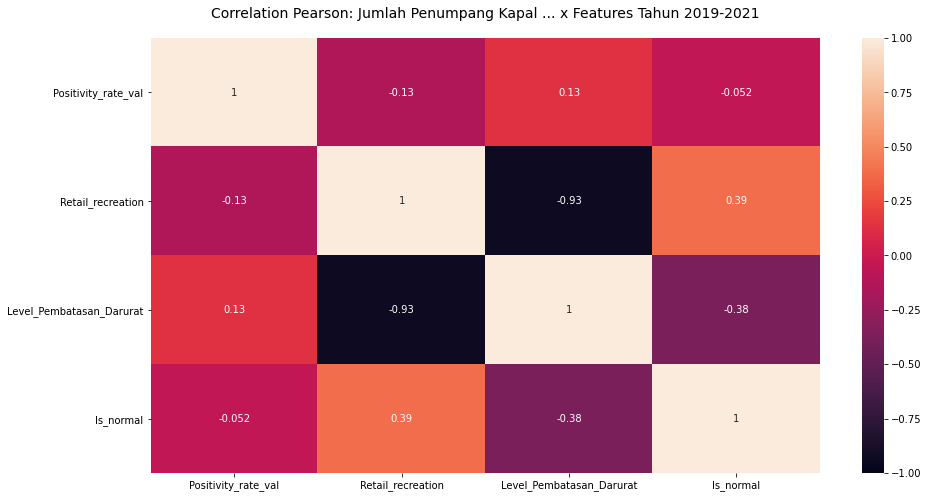

In [9]:
# Check Correlation
# visualize correlation pearson

plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(df_cont.corr(method="pearson"), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Pearson: Jumlah Penumpang Kapal ... x Features Tahun 2019-2021', fontdict={'fontsize':14}, pad=20);

In [11]:
# check confidence of correlation
print("Check confidence of correlation")
model = ols("Is_normal ~ Level_Pembatasan_Darurat", data=df_cont).fit()
print(model.summary())

Check confidence of correlation
                            OLS Regression Results                            
Dep. Variable:              Is_normal   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     880.4
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          6.97e-179
Time:                        15:57:11   Log-Likelihood:                -3240.7
No. Observations:                5202   AIC:                             6485.
Df Residuals:                    5200   BIC:                             6499.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [12]:
# setup dataset

reg01 = setup(data=df_cont, target='Is_normal', session_id = 2228)

Setup Succesfully Completed!


,Description,Value
0,session_id,2228
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(5202, 4)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [13]:
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6191,0.6820,0.9402,0.5071,0.6587,0.3067,0.3858,0.1294
1,CatBoost Classifier,0.6188,0.6820,0.9402,0.5069,0.6586,0.3063,0.3854,1.8758
2,Ada Boost Classifier,0.6185,0.6808,0.9402,0.5067,0.6584,0.3059,0.3851,0.1132
3,Quadratic Discriminant Analysis,0.6180,0.6762,0.9416,0.5064,0.6585,0.3053,0.3853,0.0032
4,Logistic Regression,0.6177,0.6775,0.9416,0.5062,0.6583,0.3049,0.3849,0.0757
5,Naive Bayes,0.6177,0.6792,0.9416,0.5062,0.6583,0.3049,0.3849,0.0034
6,Ridge Classifier,0.6177,0.0000,0.9416,0.5062,0.6583,0.3049,0.3849,0.0110
7,Linear Discriminant Analysis,0.6177,0.6769,0.9416,0.5062,0.6583,0.3049,0.3849,0.0070
8,Decision Tree Classifier,0.6171,0.6789,0.9402,0.5057,0.6576,0.3037,0.3832,0.0035
9,Extra Trees Classifier,0.6171,0.6789,0.9402,0.5057,0.6576,0.3037,0.3832,0.1692


In [14]:
# create model
cm = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5890,0.6529,0.9441,0.4874,0.6429,0.2609,0.3474
1,0.6456,0.7046,0.9441,0.5273,0.6767,0.3480,0.4240
2,0.6099,0.6768,0.9507,0.5000,0.6553,0.2947,0.3818
3,0.6236,0.6868,0.9437,0.5095,0.6617,0.3143,0.3950
4,0.6621,0.7175,0.9648,0.5373,0.6902,0.3789,0.4614
5,0.5687,0.6381,0.9155,0.4727,0.6235,0.2245,0.2977
6,0.6126,0.6785,0.9366,0.5019,0.6536,0.2959,0.3749
7,0.6484,0.7087,0.9507,0.5273,0.6784,0.3544,0.4332
8,0.6209,0.6823,0.9155,0.5078,0.6533,0.3040,0.3715
9,0.6099,0.6737,0.9366,0.5000,0.6520,0.2916,0.3712


In [21]:
# tune model
tuned_ = tune_model(cm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5863,0.6501,0.9441,0.4856,0.6413,0.2568,0.3436
1,0.6346,0.6855,0.9441,0.5192,0.6700,0.3307,0.4091
2,0.6099,0.6764,0.9507,0.5000,0.6553,0.2947,0.3818
3,0.6236,0.6883,0.9437,0.5095,0.6617,0.3143,0.3950
4,0.6621,0.7176,0.9648,0.5373,0.6902,0.3789,0.4614
5,0.5687,0.6389,0.9155,0.4727,0.6235,0.2245,0.2977
6,0.6099,0.6739,0.9366,0.5000,0.6520,0.2916,0.3712
7,0.6429,0.7002,0.9577,0.5231,0.6766,0.3472,0.4310
8,0.6181,0.6793,0.9225,0.5058,0.6534,0.3012,0.3725
9,0.6099,0.6742,0.9366,0.5000,0.6520,0.2916,0.3712


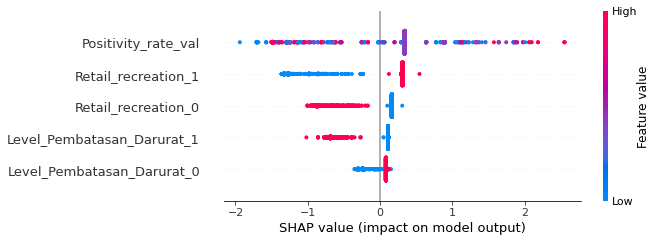

In [22]:
interpret_model(tuned_)

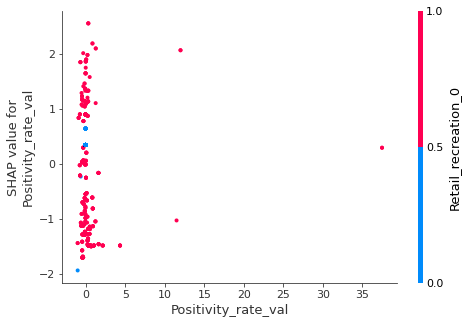

In [27]:
interpret_model(tuned_, plot = 'correlation')

In [23]:
# predict test set
dff_output = predict_model(tuned_)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6169,0.6821,0.9557,0.5048,0.6606,0.3065,0.3951


In [24]:
dff_output.head()

,Positivity_rate_val,Retail_recreation_0,Retail_recreation_1,Level_Pembatasan_Darurat_0,Level_Pembatasan_Darurat_1,Is_normal,Label,Score
0,0.000000,0.0,1.0,1.0,0.0,1,1,0.5084
1,-0.455090,1.0,0.0,0.0,1.0,1,0,0.1706
2,0.000000,0.0,1.0,1.0,0.0,1,1,0.5084
3,0.000000,0.0,1.0,1.0,0.0,1,1,0.5084
4,-0.315315,1.0,0.0,0.0,1.0,0,0,0.0040


In [26]:
# predict, evaluate
from sklearn.metrics import classification_report

print(classification_report(dff_output['Is_normal'], dff_output['Label']))

              precision    recall  f1-score   support

           0       0.93      0.40      0.56       952
           1       0.50      0.96      0.66       609

    accuracy                           0.62      1561
   macro avg       0.72      0.68      0.61      1561
weighted avg       0.77      0.62      0.60      1561



-ini

In [16]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [19]:
df_apri = df_cont[["Retail_recreation", "Level_Pembatasan_Darurat", "Is_normal"]]

frequent_itemsets = apriori(df_apri, min_support=0.01, use_colnames=True)

In [20]:
frequent_itemsets = frequent_itemsets.sort_values(by=['support'], ascending=False)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Retail_recreation),(Is_normal),0.740484,0.390427,0.371780,0.502077,1.285969,0.082675,1.224232
1,(Is_normal),(Retail_recreation),0.390427,0.740484,0.371780,0.952240,1.285969,0.082675,5.433774
2,(Level_Pembatasan_Darurat),(Is_normal),0.254325,0.390427,0.018454,0.072562,0.185854,-0.080841,0.657266
3,(Is_normal),(Level_Pembatasan_Darurat),0.390427,0.254325,0.018454,0.047267,0.185854,-0.080841,0.782669
4,(Retail_recreation),(Level_Pembatasan_Darurat),0.740484,0.254325,0.010381,0.014019,0.055121,-0.177943,0.756277
